# Binary Classification Deep Learning Model for Cats and Dogs Using Keras Take 9
## David Lowe
## February 20, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. Jason Brownlee of Machine Learning Mastery posted a tutorial on deep learning using Kaggle's Cats and Dogs dataset. [https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/]

Jason's script utilized the stochastic gradient descent and momentum (SGD) optimizer for his experiments. This script will replicate the same experiments with the Adam optimizer (with a learning rate of 0.001), so we can observe how different optimizers affect the model's performance.

ANALYSIS: For the one block VGG model, the SGD optimizer achieved an accuracy of 72.331% after 20 epochs. The Adam optimizer achieved an accuracy of 69.253% using the same number of epochs.

For the two block VGG model, the SGD optimizer achieved an accuracy of 76.646% after 20 epochs. The Adam optimizer achieved an accuracy of 71.759% using the same number of epochs.

For the three block VGG model, the SGD optimizer achieved an accuracy of 80.184% after 20 epochs. The Adam optimizer achieved an accuracy of 73.870% using the same number of epochs.

For the VGG-3 with Dropout (0.2, 0.2, 0.2, 0.5) model, the SGD optimizer achieved an accuracy of 81.279% after 50 epochs. The Adam optimizer achieved an accuracy of 84.769% after the same number of epochs. Furthermore, another VGG-3 with Dropout (0.2, 0.3, 0.4, 0.5) model achieved an accuracy of 85.118% using Adam.

For the VGG-3 with image data augmentation model, the SGD optimizer achieved an accuracy of 85.816% after 50 epochs. The Adam optimizer achieved an accuracy of 91.449% after the same number of epochs.

For the VGG-3 with Dropout (0.2, 0.3, 0.4, 0.5) and image data augmentation model, the Adam optimizer achieved an accuracy of 90.227% after 50 epochs.

Dataset Used: Cats and Dogs Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.microsoft.com/en-us/download/details.aspx?id=54765

One potential source of performance benchmarks: https://www.kaggle.com/c/dogs-vs-cats/overview


## Section 0. Prepare Environment

In [0]:
# Set the random seed number for reproducible results
seedNum = 1

In [2]:
# Set the TensorFlow version to 2.x in Colab
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot
from matplotlib.image import imread
from datetime import datetime
from email.message import EmailMessage

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Feb 11 19:53:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	fig, axs = pyplot.subplots(2, 1, figsize=(12,12))
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='red', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='red', label='test')
	pyplot.show()

In [6]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the mountStorage flag to mount G Drive for storing files (setting True will mount the drive!)
mountStorage = False

Num GPUs Available:  1


In [0]:
# Colab-Specific Setup - Mount Google Drive for storing downloaded files
if (mountStorage):
    from google.colab import drive
    drive.mount('/content/gdrive')

In [0]:
# Set the default optimizer for the remaining portion of the script
default_opt = Adam(learning_rate=0.001)

## Section 1. Data Preparation

In [9]:
!wget https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
!unzip train.zip > unzip_output.txt

--2020-02-11 19:53:19--  https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.35.33.119, 13.35.33.19, 13.35.33.20, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.35.33.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 543.16M  19.0MB/s    in 29s     

2020-02-11 19:53:49 (18.4 MB/s) - ‘train.zip’ saved [569546721/569546721]



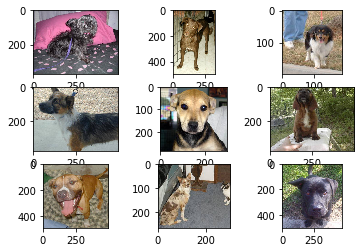

In [10]:
# plot dog photos from the dogs vs cats dataset

# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

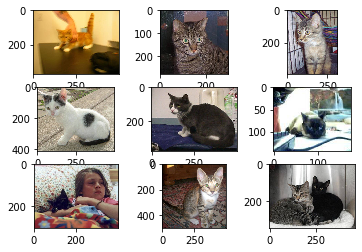

In [11]:
# plot cat photos from the dogs vs cats dataset

# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [0]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(seedNum)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

## Section 2. Fit and Evaluate Models

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 99 steps
Epoch 1/20
293/293 [==============================] - 85s 291ms/step - loss: 1.7963 - accuracy: 0.6353 - val_loss: 0.7077 - val_accuracy: 0.6432
Epoch 2/20
293/293 [==============================] - 78s 267ms/step - loss: 0.4471 - accuracy: 0.7892 - val_loss: 0.5843 - val_accuracy: 0.7170
Epoch 3/20
293/293 [==============================] - 78s 267ms/step - loss: 0.2995 - accuracy: 0.8727 - val_loss: 0.6625 - val_accuracy: 0.7158
Epoch 4/20
293/293 [==============================] - 79s 269ms/step - loss: 0.2031 - accuracy: 0.9251 - val_loss: 0.7456 - val_accuracy: 0.7092
Epoch 5/20
293/293 [==============================] - 78s 267ms/step - loss: 0.1298 - accuracy: 0.9592 - val_loss: 0.8358 - val_accuracy: 0.7136
Epoch 6/20
293/293 [==============================] - 78s 268ms/step - loss: 0.1052 - accuracy: 0

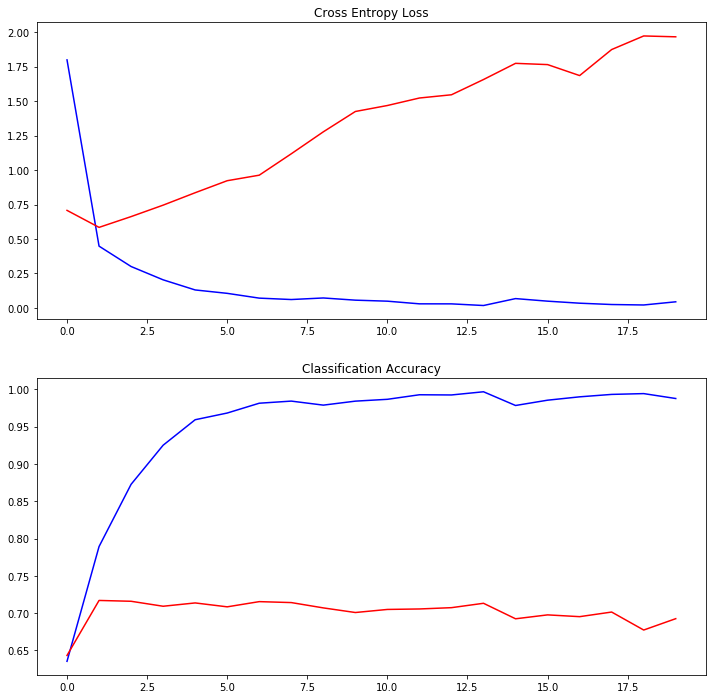

Total time for the model processing: 0:26:24.439040


In [0]:
# baseline model with One Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model1 = define_model1()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model1.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model1.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 99 steps
Epoch 1/20
293/293 [==============================] - 80s 272ms/step - loss: 1.5500 - accuracy: 0.6267 - val_loss: 0.5893 - val_accuracy: 0.6894
Epoch 2/20
293/293 [==============================] - 78s 268ms/step - loss: 0.5320 - accuracy: 0.7286 - val_loss: 0.5599 - val_accuracy: 0.7176
Epoch 3/20
293/293 [==============================] - 78s 265ms/step - loss: 0.4294 - accuracy: 0.7941 - val_loss: 0.5934 - val_accuracy: 0.7185
Epoch 4/20
293/293 [==============================] - 79s 268ms/step - loss: 0.2994 - accuracy: 0.8721 - val_loss: 0.6649 - val_accuracy: 0.7155
Epoch 5/20
293/293 [==============================] - 78s 266ms/step - loss: 0.1711 - accuracy: 0.9349 - val_loss: 0.8297 - val_accuracy: 0.7227
Epoch 6/20
293/293 [==============================] - 78s 267ms/step - loss: 0.0831 - accuracy: 0

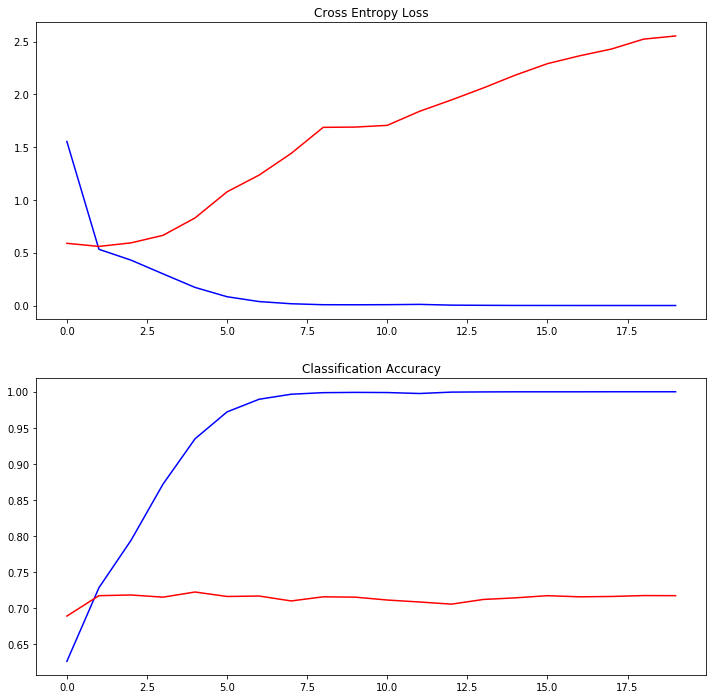

Total time for the model processing: 0:26:49.184073


In [0]:
# baseline model with Two Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model2 = define_model2()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model2.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model2.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 99 steps
Epoch 1/20
293/293 [==============================] - 81s 276ms/step - loss: 1.2080 - accuracy: 0.6356 - val_loss: 0.5999 - val_accuracy: 0.6724
Epoch 2/20
293/293 [==============================] - 80s 273ms/step - loss: 0.5677 - accuracy: 0.7038 - val_loss: 0.5733 - val_accuracy: 0.7011
Epoch 3/20
293/293 [==============================] - 80s 275ms/step - loss: 0.5192 - accuracy: 0.7398 - val_loss: 0.5367 - val_accuracy: 0.7341
Epoch 4/20
293/293 [==============================] - 80s 272ms/step - loss: 0.4761 - accuracy: 0.7702 - val_loss: 0.5223 - val_accuracy: 0.7468
Epoch 5/20
293/293 [==============================] - 80s 272ms/step - loss: 0.4313 - accuracy: 0.7994 - val_loss: 0.5840 - val_accuracy: 0.7214
Epoch 6/20
293/293 [==============================] - 80s 272ms/step - loss: 0.3835 - accuracy: 0

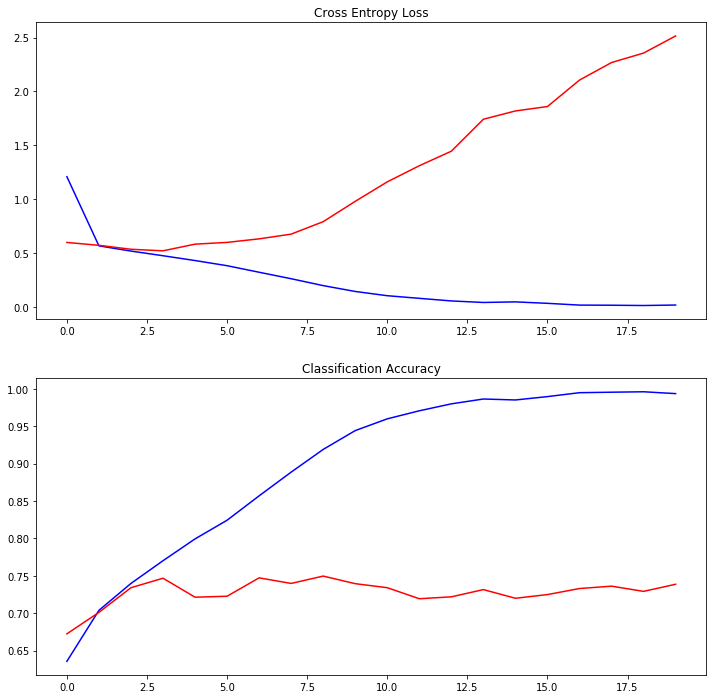

Total time for the model processing: 0:26:52.564797


In [0]:
# baseline model with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model3():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model3 = define_model3()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model3.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model3.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 99 steps
Epoch 1/50
293/293 [==============================] - 84s 288ms/step - loss: 0.9851 - accuracy: 0.5894 - val_loss: 0.5930 - val_accuracy: 0.6662
Epoch 2/50
293/293 [==============================] - 82s 281ms/step - loss: 0.5645 - accuracy: 0.7059 - val_loss: 0.5682 - val_accuracy: 0.6855
Epoch 3/50
293/293 [==============================] - 83s 283ms/step - loss: 0.5254 - accuracy: 0.7357 - val_loss: 0.5055 - val_accuracy: 0.7435
Epoch 4/50
293/293 [==============================] - 83s 282ms/step - loss: 0.4775 - accuracy: 0.7746 - val_loss: 0.4496 - val_accuracy: 0.7917
Epoch 5/50
293/293 [==============================] - 83s 283ms/step - loss: 0.4392 - accuracy: 0.7950 - val_loss: 0.5099 - val_accuracy: 0.7373
Epoch 6/50
293/293 [==============================] - 82s 280ms/step - loss: 0.4025 - accuracy: 0

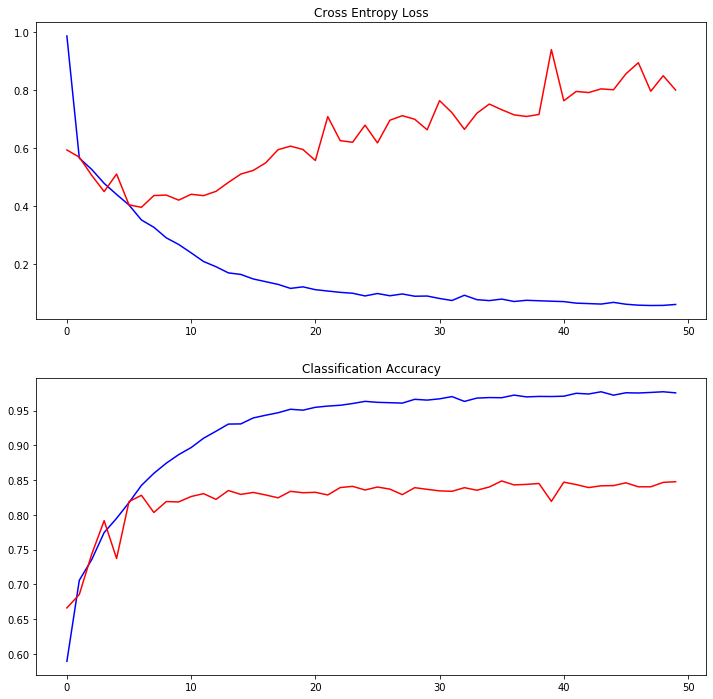

Total time for the model processing: 1:09:24.946451


In [0]:
# baseline model with VGG-3 and dropout (variation #1)
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model4():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model4 = define_model4()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model4.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model4.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 99 steps
Epoch 1/50
293/293 [==============================] - 80s 275ms/step - loss: 0.8680 - accuracy: 0.5962 - val_loss: 0.5938 - val_accuracy: 0.6641
Epoch 2/50
293/293 [==============================] - 71s 244ms/step - loss: 0.5857 - accuracy: 0.6818 - val_loss: 0.5478 - val_accuracy: 0.7057
Epoch 3/50
293/293 [==============================] - 72s 245ms/step - loss: 0.5420 - accuracy: 0.7227 - val_loss: 0.5829 - val_accuracy: 0.6833
Epoch 4/50
293/293 [==============================] - 72s 246ms/step - loss: 0.4936 - accuracy: 0.7557 - val_loss: 0.4707 - val_accuracy: 0.7784
Epoch 5/50
293/293 [==============================] - 72s 247ms/step - loss: 0.4398 - accuracy: 0.7951 - val_loss: 0.4294 - val_accuracy: 0.7985
Epoch 6/50
293/293 [==============================] - 72s 247ms/step - loss: 0.4015 - accuracy: 0

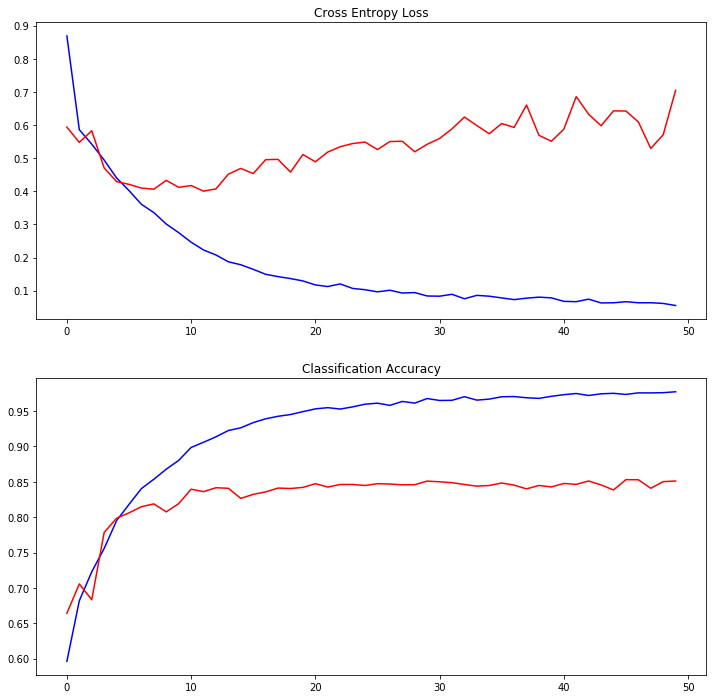

Total time for the model processing: 1:01:32.942103


In [0]:
# baseline model with VGG-3 and dropout (variation #2)
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model5():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model5 = define_model5()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model5.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model5.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 99 steps
Epoch 1/50
293/293 [==============================] - 206s 704ms/step - loss: 0.7963 - accuracy: 0.6224 - val_loss: 0.5745 - val_accuracy: 0.7032
Epoch 2/50
293/293 [==============================] - 205s 699ms/step - loss: 0.5326 - accuracy: 0.7294 - val_loss: 0.5047 - val_accuracy: 0.7504
Epoch 3/50
293/293 [==============================] - 205s 700ms/step - loss: 0.4894 - accuracy: 0.7638 - val_loss: 0.4743 - val_accuracy: 0.7741
Epoch 4/50
293/293 [==============================] - 203s 694ms/step - loss: 0.4447 - accuracy: 0.7932 - val_loss: 0.4473 - val_accuracy: 0.7896
Epoch 5/50
293/293 [==============================] - 204s 695ms/step - loss: 0.4153 - accuracy: 0.8131 - val_loss: 0.3885 - val_accuracy: 0.8269
Epoch 6/50
293/293 [==============================] - 205s 700ms/step - loss: 0.3983 - accur

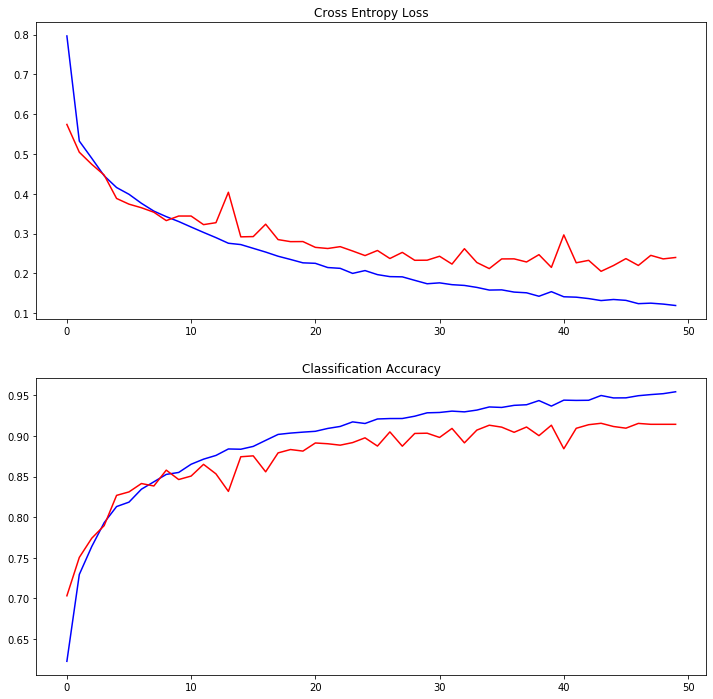

Total time for the model processing: 2:46:11.113173


In [0]:
# baseline model with VGG-3 and image data augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model6():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model6 = define_model6()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model6.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model6.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 99 steps
Epoch 1/50
293/293 [==============================] - 207s 707ms/step - loss: 0.9716 - accuracy: 0.5732 - val_loss: 0.6010 - val_accuracy: 0.6573
Epoch 2/50
293/293 [==============================] - 201s 685ms/step - loss: 0.6061 - accuracy: 0.6595 - val_loss: 0.5541 - val_accuracy: 0.7133
Epoch 3/50
293/293 [==============================] - 200s 683ms/step - loss: 0.5721 - accuracy: 0.6978 - val_loss: 0.5315 - val_accuracy: 0.7231
Epoch 4/50
293/293 [==============================] - 199s 679ms/step - loss: 0.5405 - accuracy: 0.7248 - val_loss: 0.4924 - val_accuracy: 0.7530
Epoch 5/50
293/293 [==============================] - 198s 676ms/step - loss: 0.5133 - accuracy: 0.7472 - val_loss: 0.4824 - val_accuracy: 0.7573
Epoch 6/50
293/293 [==============================] - 197s 673ms/step - loss: 0.4896 - accur

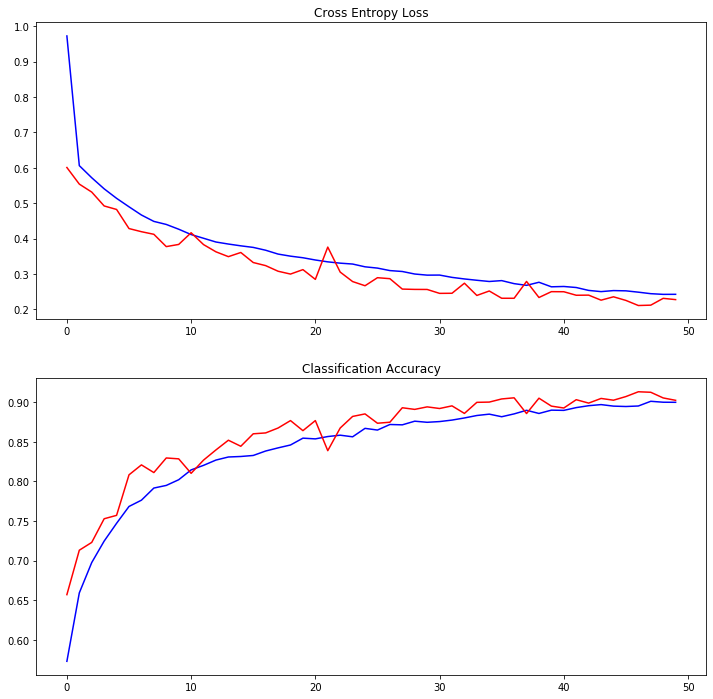

Total time for the model processing: 2:48:38.136593


In [13]:
# baseline model with VGG-3, dropout, and image data augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model7():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model7 = define_model7()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model7.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model7.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))